In [51]:
#%% Load Modules
startup_file='init_python.py'
exec(open(startup_file).read())
from matplotlib.patches import Rectangle

In [1]:
# DEFINE PARAMETERS FROM SIMULATION 


N_ensemble = 1    #number of ensembles created for freely evoling sumilations. Used for averaging data

file_start = 1  #define the start/end files for plotting
file_end = 1200

dt = 0.0005  #time between files (0.5 factor due to change in equation). Simulation time = dt * filenumber

#initial injection scale in k- and freq-space
kf = 64
wf = kf**2.0


L = 2.0*np.pi   #box size
N = 2048        #number of spatial grid points in data

#fluxes defined from initial forcing
wave_action_flux = 2.0 * 32.12
energy_flux = 2.0 * 8.41969e6

#fit regions for T/mu
kmin_low = 1
kmax_low = 8

#fit regions for T/\omega
kmin_high = 200
kmax_high = 400


NameError: name 'np' is not defined

In [ ]:
# DEFINE GIBBS FUNCTION
def Gibbs_function(x,a):
    return 1.0/( (x/a) + 1.0)

In [2]:
def convert_k_to_omega(k,n_k):

    n_omega = n_k[1:]/(2.0*k[1:]) 	# n_2d/2k = 1d sepctrum in freq space
    omega = k[1:]**2	
    
    return omega, n_omega

In [3]:
def estimate_mu_T(omega,n_omega):
    
	# normalisationValue = T/\mu
	#normalisationValue = np.max(n_omega[0:(3*kf//4)])				#Simon's computation of nomralisationValue =  maxValue
	normalisationValue = np.mean(n_omega[kmin_low:kmax_low])			#Alternative computation of nomralisationValue =  meanValue
	
	omega_fit = omega[0:2*kf//4]
	n_fit = n_omega[0:2*kf//4] / normalisationValue
		
	mu_est, pcov = curve_fit(Gibbs_function, omega_fit, n_fit)

	T = mu_est * normalisationValue
	mu = mu_est
    
	return mu, T

In [56]:
def selfsimilar_variables(omega,n_omega, mu, T):
    eta = omega / mu
    phi = (mu / T) * n_omega 

    return eta, phi

def logcorrected_selfsimilar_variables(omega,n_omega, mu, T, eta_plus):
    eta_prime = omega / (eta_plus* mu)
    phi_prime = (eta_plus * mu/ T) * n_omega 

    return eta_prime, phi_prime

In [57]:
#DECALRE DATA ARRAYS FOR ANALYSIS

n_k = np.zeros(N)
temp = np.zeros(file_end-file_start+1)
mu =  np.zeros(file_end-file_start+1)
time = np.zeros(file_end-file_start+1)
eta_plus = np.zeros(file_end-file_start+1)


time_data = []
mu_data = []
T_data = []


In [58]:
def find_eta_plus(x, y):  # x = eta, y = eta * phi
    threshold = 0.1
    i = len(y)-1           # end index of y array
    val = y[i]              # record value. should be close to zero
    while val < threshold:
        i = i - 1           # go through array backwards
        val = y[i]
       
        if i==0:
            val=1
    return eta[i]                    # once value goes over threshold, return the value of eta at index

/tmp/ipykernel_32357/4091072498.py:145: RuntimeWarning: invalid value encountered in power
  Log_fit = 1.0/(eta * np.log(c1/eta)**-0.33  + 1.0 )
/tmp/ipykernel_32357/4091072498.py:185: RuntimeWarning: invalid value encountered in power
  Log_fit = 1.0/(eta * np.log(c1/eta)**-0.33  + 1.0 )


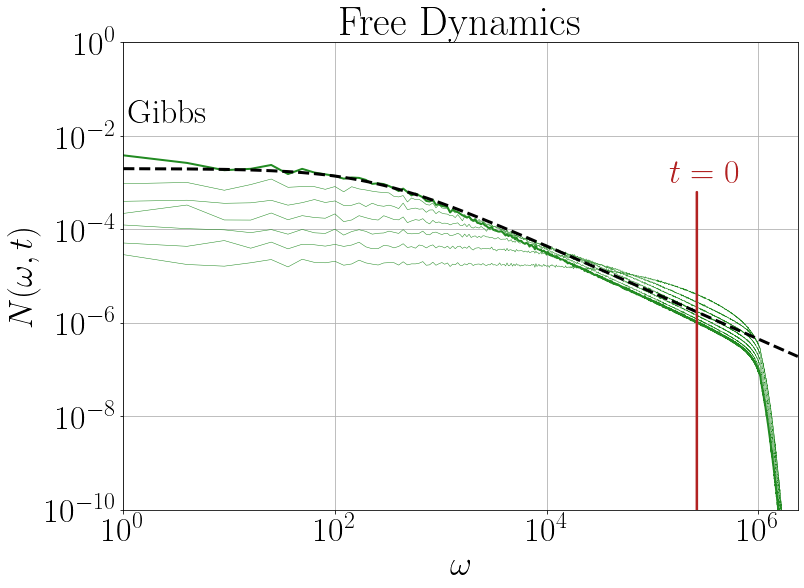

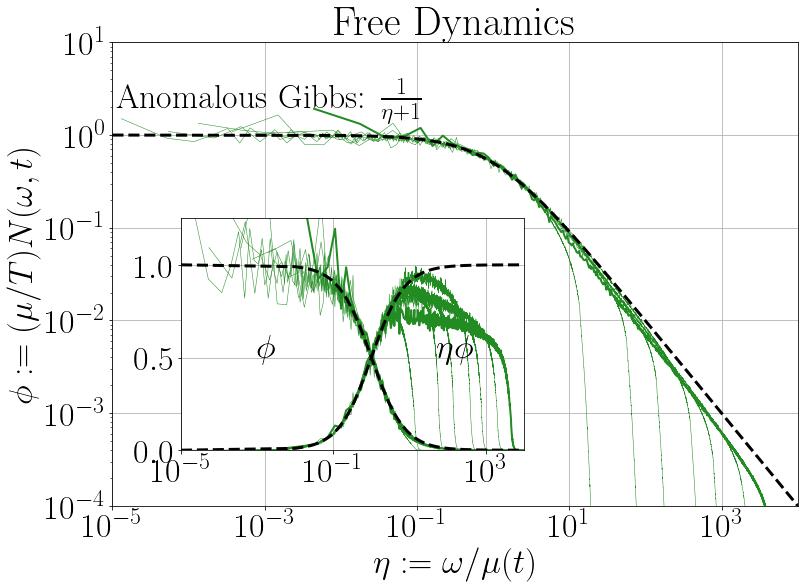

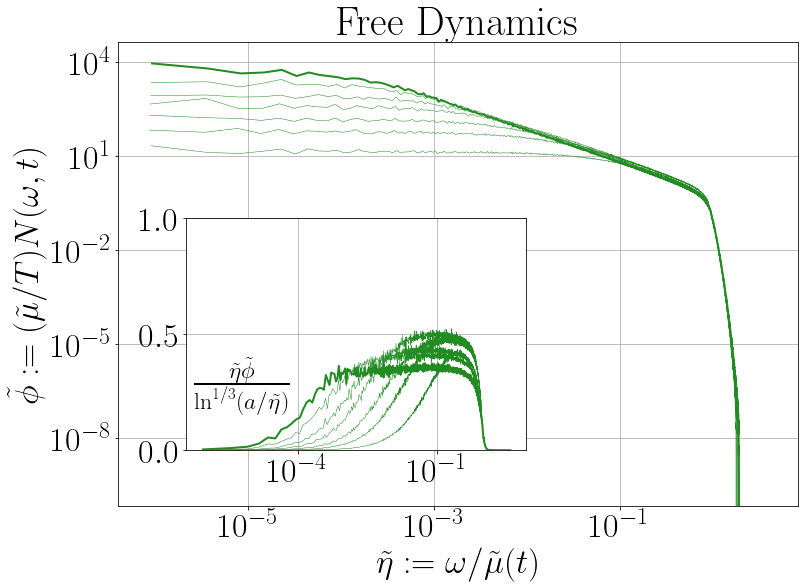

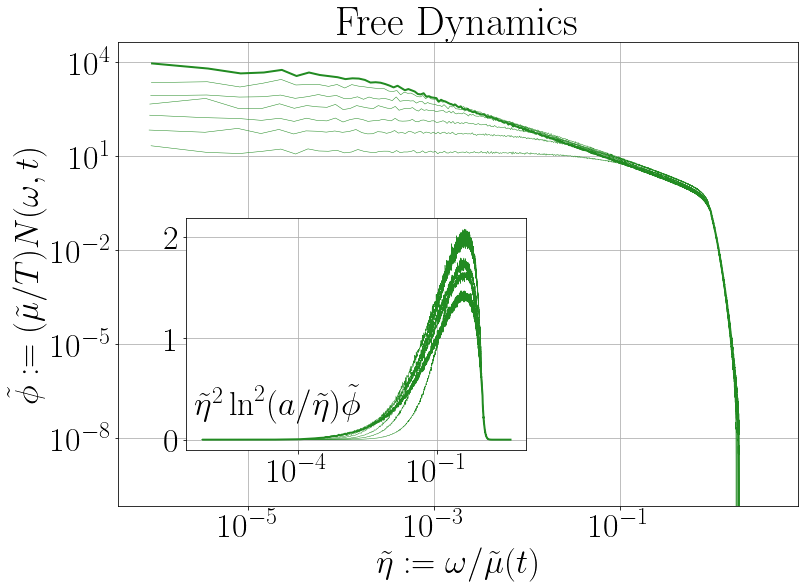

In [64]:
fig1, axs1 = newfig(1, 1)

fig2, axs2 = newfig(1, 1)
axs2a = axs2.inset_axes([0.1,0.12,0.5,0.5])#axs2,width="50%", height="45%", loc='lower left',borderpad=3)

fig3, axs3 = newfig(1,1)
axs3a = axs3.inset_axes([0.1,0.12,0.5,0.5])

fig4, axs4 = newfig(1,1)
axs4a = axs4.inset_axes([0.1,0.12,0.5,0.5])

index = 0


for file_num in range(file_start+25,file_end+1,25):	#loop over data, every 25 files

	time = file_num * dt		# define simulation time
	n_k = 0.0
	
	#average over ensembles
	for ensemble_num in range(1,N_ensemble,1):
		#filename = '/data2/2d_gp_selfsimilar/decay_at_512_ensemble_%.1d/output/spectrum.%.5d' % (ensemble_num,file_num);
		filename = '~/Dropbox/output/spectrum.%.6d' % (file_num);
		data = np.loadtxt(filename)
		n_k += data[:,1]
        
	
	n_k /= N_ensemble   # this is the 2d spectrum  
	k = data[:,0]		



	omega, n_omega = convert_k_to_omega(k,n_k)


	if file_num == file_start:			# compute total energy and wave action from initial file
		total_wave_action = np.sum(n_k)
		total_energy = 0.5 * np.sum(k * k * n_k)


	mu, T = estimate_mu_T(omega, n_omega)

	time_data.append(time)
	mu_data.append(mu)
	T_data.append(T)

	

	eta, phi = selfsimilar_variables(omega,n_omega, mu, T)

	eta_plus = find_eta_plus(eta, eta*phi)

	eta_prime, phi_prime = logcorrected_selfsimilar_variables(omega,n_omega, mu, T, eta_plus)
	

	axs1.plot(omega, n_omega, linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))    						# plots the wave action spectrum (not rescaled)					
	
	axs2.plot(eta, phi, linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))					# plots the re-scaled wave action spectrum
	axs2a.plot(eta, phi, linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))					# plots the rescaled wave action spectrum in lin-log as insert
	axs2a.plot(eta, eta*phi, linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))	# plots the rescaled wave action spectrum (compensated by omega) in lin-log as insert


	c1=5.e1
	axs3.plot(eta_prime, phi_prime, linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))					# plots the rescaled wave action spectrum in lin-log as insert
	axs3a.plot(eta_prime, eta_prime*phi_prime/ (np.log(c1/eta_prime)**0.33), linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))	
	
	c2=5.e0
	axs4.plot(eta_prime, phi_prime, linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))					# plots the rescaled wave action spectrum in lin-log as insert
	axs4a.plot(eta_prime, eta_prime**2.0 * (np.log(c2/eta_prime)**2.0) * phi_prime, linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))	

axs1.plot(omega, n_omega, linewidth=2,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))										# plots the wave action spectrum (not rescaled)	

axs2.plot(eta, phi, linewidth=2,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))							# plots the re-scaled wave action spectrum
axs2a.plot(eta, phi, linewidth=2,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))							# plots the rescaled wave action spectrum in lin-log as insert
axs2a.plot(eta, eta*phi, linewidth=2,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))				# plots the rescaled wave action spectrum (compensated by omega) in lin-log as insert
	

axs3.plot(eta_prime, phi_prime, linewidth=2,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))	
axs3a.plot(eta_prime, eta_prime*phi_prime/(np.log(c1/eta_prime)**0.33), linewidth=2,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))	

axs4.plot(eta_prime, phi_prime, linewidth=2,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))	
axs4a.plot(eta_prime, eta_prime**2.0 * (np.log(c2/eta_prime)**2.0) * phi_prime, linewidth=2,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))	

Gibbs = (T/mu) * 1.0 / (1.0 + eta)																							# define theoretical Gibbs solution
axs1.plot(omega[:], Gibbs[:],linewidth=3,label=r'$Gibbs$', color='black', linestyle='--')									# plots the theoretical gibbs solution on wave action spectrum


initial=0.0*omega
initial[kf-2:kf+2]=0.0001*2*np.pi
axs1.plot(omega, initial, linewidth=2,c='firebrick')																			# plot the initial spectrum on wave action spectrum


axs1.annotate(text=r'Gibbs',xy=(1.1,2.e-2),c='k')
axs1.annotate(text='$t=0$',xy=(wf-120000,1e-3),c='firebrick')
axs1.grid()
axs1.set_xlabel(r'$\omega$')
axs1.set_ylabel(r'$N(\omega,t)$')
axs1.set_yscale('log')
axs1.set_xscale('log')
axs1.set_xlim(1,(1024*1.5)**2)
axs1.set_ylim(1.e-10,1.e0)
#axs1.legend(loc='best', ncol=2)
axs1.set_title('Free Dynamics')
fig1.tight_layout()

fig1.savefig('spectrum_decay.pdf')


##################################################################################################################
eta = np.arange(1.e-5,1.e5,0.01)
Gibbs_fit = 1.0 / (eta+1.0)
axs2.plot(eta, Gibbs_fit,linewidth=3,label=r'$Gibbs$', color='black', linestyle='--')
axs2a.plot(eta, Gibbs_fit,linewidth=3,label=r'$Gibbs$', color='black', linestyle='--')
axs2a.plot(eta, eta*Gibbs_fit,linewidth=3,label=r'$Gibbs$', color='black', linestyle='--')


axs2a.set_yscale('linear')
axs2a.set_xscale('log')
axs2a.set_xlim(1e-5,1e4)
axs2a.set_ylim(0,1.25)
axs2a.annotate(text=r'$\phi$',xy=(1.e-3,0.5),c='k')
axs2a.annotate(text=r'$\eta\phi$',xy=(5.e1,0.5),c='k')
axs2a.grid()

axs2.annotate(text=r'Anomalous Gibbs: $\frac{1}{\eta+1}$',xy=(1.1e-5,2.e0),c='k')
#axs2.annotate(text='$\leftarrow f_0$',xy=(wf,1e-4),c='firebrick')
axs2.grid()
axs2.set_xlabel(r'$\eta:=\omega/\mu(t)$')
axs2.set_ylabel(r'$\phi:=(\mu/T)N(\omega,t)$')
axs2.set_yscale('log')
axs2.set_xscale('log')
axs2.set_xlim(1e-5,1e4)
axs2.set_ylim(1.e-4,1.e1)
#axs1.legend(loc='best', ncol=2)

axs2.set_title('Free Dynamics')

fig2.tight_layout()

fig2.savefig('gibbs_decay.pdf')

######################################################################################

eta = np.arange(1.e-5,1.e5,0.01)
Gibbs_fit = 1.0 / (eta+1.0)
Log_fit = 1.0/(eta * np.log(c1/eta)**-0.33  + 1.0 )


axs3a.set_yscale('linear')
axs3a.set_xscale('log')
#axs3a.set_xlim(1e-5,1e4)
axs3a.set_ylim(0,1)
#axs3a.annotate(text=r'$\phi$',xy=(1.e-3,0.5),c='k')
axs3a.annotate(text=r'$\frac{\tilde{\eta}\tilde{\phi}}{\ln^{1/3}(a/\tilde{\eta})}$',xy=(6.e-7,0.25),c='k')
axs3a.grid()


#axs3.plot(eta, eta*Gibbs_fit,linewidth=3,label=r'$Gibbs$', color='black', linestyle='--')
#axs3.plot(eta, eta*Log_fit,linewidth=3,label=r'$Gibbs$', color='red', linestyle='--')
axs3.set_yscale('log')
axs3.set_xscale('log')
#axs3.set_xlim(1e-5,5e3)
#axs3.set_ylim(0,1.25)

axs3.grid()



axs3.set_xlabel(r'$\tilde{\eta}:=\omega/\tilde{\mu}(t)$')
axs3.set_ylabel(r'$\tilde{\phi}:=(\tilde{\mu}/T)N(\omega,t)$')

#axs4.set_ylim(1.e-4,1.e1)
#axs1.legend(loc='best', ncol=2)

axs3.set_title('Free Dynamics')

fig3.tight_layout()

fig3.savefig('gibbs_log_decay.pdf')


######################################################################################

eta = np.arange(1.e-5,1.e5,0.01)
Gibbs_fit = 1.0 / (eta+1.0)
Log_fit = 1.0/(eta * np.log(c1/eta)**-0.33  + 1.0 )


axs4a.set_yscale('linear')
axs4a.set_xscale('log')
#axs3a.set_xlim(1e-5,1e4)
#axs4a.set_ylim(0,1)
#axs3a.annotate(text=r'$\phi$',xy=(1.e-3,0.5),c='k')
axs4a.annotate(text=r'$\tilde{\eta}^2\ln^2(a/\tilde{\eta})\tilde{\phi}$',xy=(6.e-7,0.25),c='k')
axs4a.grid()


#axs3.plot(eta, eta*Gibbs_fit,linewidth=3,label=r'$Gibbs$', color='black', linestyle='--')
#axs3.plot(eta, eta*Log_fit,linewidth=3,label=r'$Gibbs$', color='red', linestyle='--')
axs4.set_yscale('log')
axs4.set_xscale('log')
#axs3.set_xlim(1e-5,5e3)
#axs3.set_ylim(0,1.25)

axs4.grid()



axs4.set_xlabel(r'$\tilde{\eta}:=\omega/\tilde{\mu}(t)$')
axs4.set_ylabel(r'$\tilde{\phi}:=(\tilde{\mu}/T)N(\omega,t)$')

#axs4.set_ylim(1.e-4,1.e1)
#axs1.legend(loc='best', ncol=2)

axs4.set_title('Free Dynamics')

fig4.tight_layout()

fig4.savefig('DPNZ_decay.pdf')





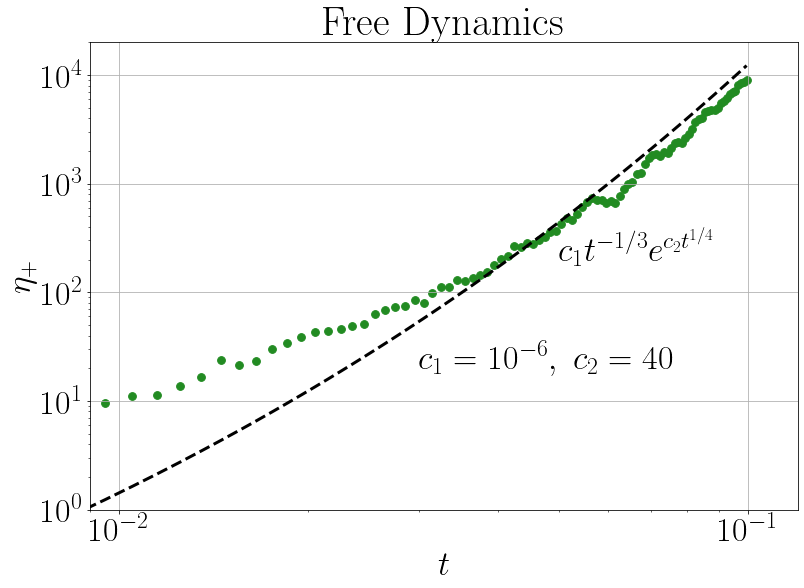

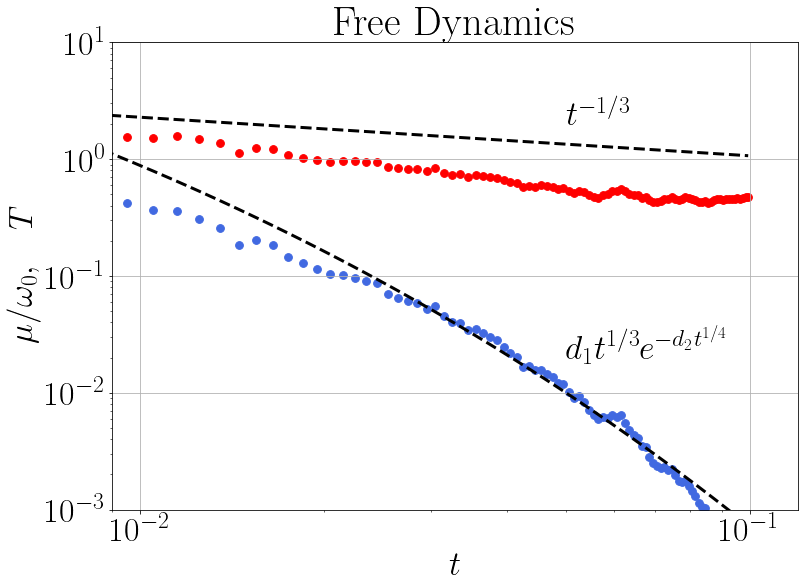

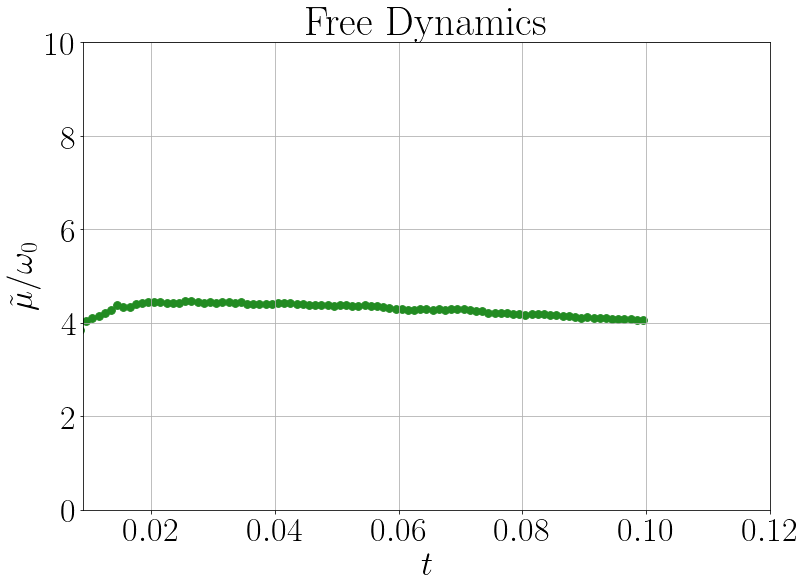

In [60]:
fig1, axs1 = newfig(1, 1)

fig2, axs2 = newfig(1, 1)

fig3, axs3 = newfig(1, 1)



for file_num in range(file_start,file_end+1,2):	#loop over data, every 25 files

	time = file_num * dt		# define simulation time
	n_k = 0.0
	
	#average over ensembles
	for ensemble_num in range(1,N_ensemble,1):
		filename = '/data2/2d_gp_selfsimilar/decay_at_512_ensemble_%.1d/output/spectrum.%.5d' % (ensemble_num,file_num);
		data = np.loadtxt(filename)
		n_k += data[:,1]
        
	
	n_k /= N_ensemble   # this is the 2d spectrum  
	k = data[:,0]		



	omega, n_omega = convert_k_to_omega(k,n_k)


	if file_num == file_start:			# compute total energy and wave action from initial file
		total_wave_action = np.sum(n_k)
		total_energy = 0.5 * np.sum(k * k * n_k)


	mu, T = estimate_mu_T(omega, n_omega)

	time_data.append(time)
	mu_data.append(mu)
	T_data.append(T)

	

	eta, phi = selfsimilar_variables(omega,n_omega, mu, T)

	eta_plus = find_eta_plus(eta, eta*phi)

	eta_prime, phi_prime = logcorrected_selfsimilar_variables(omega,n_omega, mu, T, eta_plus)
	

	axs1.scatter(time,eta_plus, c='forestgreen',s=60)
	axs2.scatter(time,mu/wf, c='royalblue',s=60)
	axs2.scatter(time,T, c='red',s=60)
	axs3.scatter(time,eta_plus*mu/wf, c='forestgreen',s=60)


	

td = np.array(time_data)

c1 = 1.e-6
c2 = 4.e1

axs1.plot(td[-100:],c1*td[-100:]**(-0.33)*np.exp(c2*td[-100:]**0.25),linewidth=3,label=r'$t^4$', color='black', linestyle='--')		


######################################################################################
axs1.set_yscale('log')
axs1.set_xscale('log')
axs1.set_xlim(9.e-3,1.2e-1)
axs1.set_ylim(1.e0,2.e4)
axs1.grid()
axs1.annotate(text=r'$c_1t^{-1/3}e^{c_2t^{1/4}}$',xy=(5.e-2,2.e2),c='k')
axs1.annotate(text=r'$c_1=10^{-6},\ c_2=40$',xy=(3.e-2,2.e1),c='k')
axs1.set_ylabel(r'$\eta_+$')
axs1.set_xlabel(r'$t$')

axs1.set_title('Free Dynamics')
fig1.tight_layout()

fig1.savefig('eta_plus_decay.pdf')

##########################################################################################################


d1 = 1.e5
d2 = 3.2e1

d3 = 5.e-1


axs2.plot(td[-100:],d1*td[-100:]**(0.33)*np.exp(-d2*td[-100:]**0.25),linewidth=3,label=r'$t^4$', color='black', linestyle='--')	

axs2.plot(td[-100:],d3*td[-100:]**(-0.33),linewidth=3,label=r'$t^4$', color='black', linestyle='--')	



axs2.set_yscale('log')
axs2.set_xscale('log')
axs2.set_xlim(9.e-3,1.2e-1)
axs2.set_ylim(1.e-3,1.e1)
axs2.grid()

axs2.annotate(text=r'$t^{-1/3}$',xy=(5.e-2,2),c='k')
axs2.annotate(text=r'$d_1t^{1/3}e^{-d_2t^{1/4}}$',xy=(5.e-2,2.e-2),c='k')


axs2.set_ylabel(r'$\mu/\omega_0, \quad T$')
axs2.set_xlabel(r'$t$')

axs2.set_title('Free Dynamics')
fig2.tight_layout()

fig2.savefig('mu_T_decay.pdf')

##########################################################################################################


axs3.set_yscale('linear')
axs3.set_xscale('linear')
axs3.set_xlim(9.e-3,1.2e-1)
axs3.set_ylim(0,10)
axs3.grid()
#axs3.annotate(text=r'$t^4$',xy=(5.e-2,1.1e3),c='k')
axs3.set_ylabel(r'$\tilde{\mu}/\omega_0$')
axs3.set_xlabel(r'$t$')

axs3.set_title('Free Dynamics')
fig3.tight_layout()

fig3.savefig('mu_tilde_decay.pdf')

##########################################################################################################
